# **PROJET DE SÉRIE TEMPORELLE | PRÉDICTION DES PRIX DES ACTIONS :**

Développez un modèle qui prédit les prix futurs des actions en se basant sur les données historiques des prix des actions.

Vous pouvez expérimenter avec divers algorithmes, tels que ARIMA, GARCH ou des modèles d'apprentissage automatique comme LSTM.

N'oubliez pas que la prédiction des prix des actions est une tâche complexe et qu'il est notoirement difficile de prédire ces prix avec précision en raison des nombreux facteurs qui influencent les mouvements du marché. De plus, les données historiques seules peuvent ne pas capturer toutes les informations pertinentes. Envisagez donc d'incorporer d'autres facteurs, comme le sentiment des actualités, les indicateurs économiques ou des données spécifiques à l'entreprise, pour concevoir un modèle plus complet.

# BIBLIOTHEQUES, CLASSES & FUNCTIONS

In [2]:
# Librairies
import yfinance as yf

import pandas as pd
import numpy as np
import warnings

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

from datetime import datetime

from arch import arch_model

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

import scipy.stats as stats

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tqdm import tqdm

rcParams['figure.figsize'] = 15, 6

# Ignorer les avertissements
warnings.filterwarnings("ignore")

In [3]:
# Fonctions
## Function to calculate technical indicators
def calculate_indicators(data):
    """
    Calculates technical indicators for the given data.

    Parameters:
        data (pd.DataFrame): A DataFrame containing at least a 'Close' column representing closing prices.

    Returns:
        pd.DataFrame: The original DataFrame with two additional columns:
            - 'MA10Day': 10-day moving average of the closing prices.
            - 'MA30Day': 30-day moving average of the closing prices.
    """
    data['MA10Day'] = data['Close'].rolling(window=10).mean()
    data['MA30Day'] = data['Close'].rolling(window=30).mean()
    return data

## RSI Calculation
def calculate_rsi(series, period):
    """
    Calculates the Relative Strength Index (RSI) for a given time series.

    Parameters:
        series (pd.Series): A series of prices for which RSI is to be calculated.
        period (int): The lookback period for calculating RSI.

    Returns:
        pd.Series: A series containing the RSI values.
    """
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

## Fonction to calculate mse, rmse and mae
def calculate_metrics(y_true, y_pred):
    """
    Calculates common regression metrics: Mean Squared Error (MSE), Root Mean Squared Error (RMSE),
    and Mean Absolute Error (MAE).

    Parameters:
        y_true (array-like): Ground truth (true values).
        y_pred (array-like): Predicted values.

    Returns:
        tuple: A tuple containing the following metrics:
            - mse (float): Mean Squared Error.
            - rmse (float): Root Mean Squared Error.
            - mae (float): Mean Absolute Error.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae


In [4]:
# Classe du modèle
class BiLSTMModel(nn.Module):
    """
    Modèle BiLSTM pour la prédiction de séries temporelles ou de séquences, basé sur une architecture
    de réseaux de neurones récurrents bidirectionnels (BiLSTM).

    Arguments :
    - input_size (int) : Nombre de caractéristiques d'entrée à chaque pas de temps.
    - hidden_size (int) : Nombre de neurones dans la couche cachée.
    - num_layers (int) : Nombre de couches LSTM empilées.
    - output_size (int) : Taille de la sortie du modèle, c'est-à-dire le nombre de prédictions.
    """

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Initialisation du modèle BiLSTM avec les paramètres spécifiés.

        Arguments :
        - input_size (int) : Nombre de caractéristiques d'entrée à chaque pas de temps.
        - hidden_size (int) : Nombre de neurones dans la couche cachée.
        - num_layers (int) : Nombre de couches LSTM empilées.
        - output_size (int) : Taille de la sortie du modèle.
        """
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        """
        Passe avant du modèle. Effectue la propagation avant à travers la couche LSTM et la couche linéaire.

        Arguments :
        - x (tensor) : Tenseur d'entrée de forme (batch_size, seq_length, input_size).

        Retour :
        - out (tensor) : Tenseur de sortie de forme (batch_size, output_size).
        """
        _, (h_n, _) = self.lstm(x)
        h_n = torch.cat((h_n[-2], h_n[-1]), dim=1)  # Concatenate both directions
        out = self.fc(h_n)

        return out


# PRÉTRAITEMENT DES DONNÉES

## Import du jeu de données

In [5]:
# Téléchargement du jeu de données
ticker = "NVDA"
start_date = "2010-01-01"
end_date = "2024-12-31"

data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [6]:
# Création de la colonne Date
nvidia_df = data.reset_index()
nvidia_df.Date = pd.to_datetime(nvidia_df.Date)

# Affichage des données
nvidia_df.head().to_csv('nvidia_df.csv')

In [7]:
nvidia_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3773 entries, 0 to 3772
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        3773 non-null   datetime64[ns]
 1   (Close, NVDA)   3773 non-null   float64       
 2   (High, NVDA)    3773 non-null   float64       
 3   (Low, NVDA)     3773 non-null   float64       
 4   (Open, NVDA)    3773 non-null   float64       
 5   (Volume, NVDA)  3773 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 177.0 KB


Chaque ligne représente les données boursières quotidiennes de l'action NVIDIA (NVDA) et les colonnes contiennent des indicateurs financiers :

>Close : Prix de clôture (valeur à la fin de la journée).

>High : Prix le plus élevé atteint dans la journée.

>Low : Prix le plus bas atteint dans la journée.

>Open : Prix à l'ouverture de la journée.

>Volume : Volume des transactions effectuées (en nombre d'actions échangées).


## Analyse Exploratoire des Données

Faisons une analyse simple de nos données pour avoir un aperçu des données traitées

In [8]:
# Statistiques descriptives
nvidia_df.drop(columns=[('Date',)]).describe().round(2)

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
count,3773.00,3773.00,3773.00,3773.00,3.773000e+03
mean,13.95,14.20,13.67,13.95,4.970860e+08
std,28.03,28.55,27.47,28.05,3.064658e+08
min,0.20,0.21,0.20,0.20,4.564400e+07
25%,0.41,0.42,0.40,0.41,3.034880e+08
50%,3.54,3.59,3.45,3.52,4.283480e+08
75%,13.56,13.82,13.33,13.59,6.025800e+08
max,148.87,152.88,146.25,149.34,3.692928e+09


- Les données montrent une forte croissance du prix de l'action NVIDIA au fil des années, avec une variabilité significative.

- Le volume de transactions est également élevé, indiquant que l'action est très liquide et fréquemment échangée.

- Les statistiques descriptives révèlent des tendances intéressantes à explorer plus en détail, comme la relation entre le volume et les variations de prix.

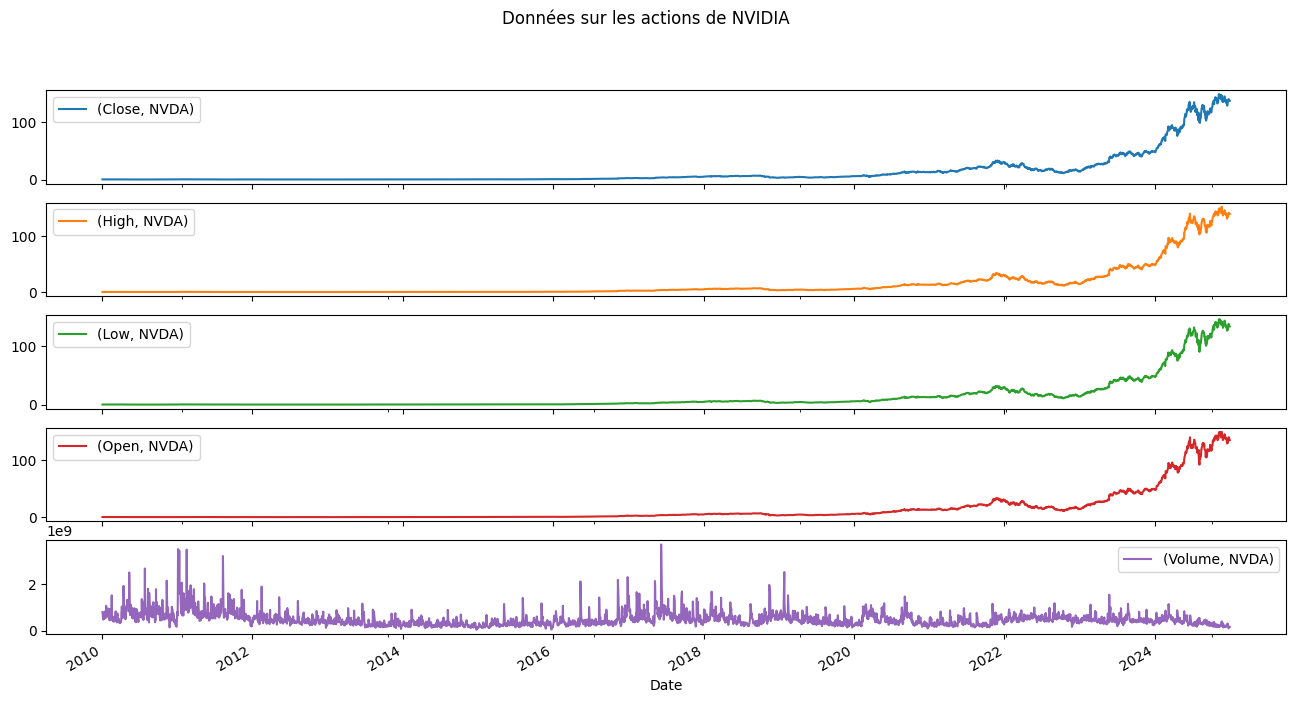

In [28]:
# Tracer toutes les colonnes par rapport à la date
nvidia_df.plot(x='Date', subplots=True, figsize=(16, 8), title='Données sur les actions de NVIDIA')
plt.show()

- **Prices**
   - Le graphique montre clairement l'évolution des **prix de l'action** au fil du temps. On observe une **croissance exponentielle** des prix à partir de certaines périodes, surtout après 2020. Ces variations sont probablement liées à des événements marquants, comme des annonces importantes ou des résultats financiers qui ont eu un fort impact.
   - On remarque aussi des **périodes de forte volatilité**, où le prix fluctue de manière significative. Ces fluctuations peuvent être le résultat d'événements externes ou de changements dans les conditions du marché, affectant directement l'action de NVIDIA.

- **Volume**
   - Le graphique du **volume de transactions** nous montre l'intensité des échanges d'actions. On peut facilement repérer des **pics de volume**, qui sont souvent associés à des événements majeurs pour la société, tels que des lancements de produits, des résultats financiers ou même des événements de marché comme des crises économiques ou des événements politiques.
   - En dehors de ces pics, on observe des périodes où le volume reste relativement **stable**, ce qui peut indiquer que le marché est dans une phase plus calme, sans grands changements ou nouvelles importantes.

- **Croissance**
   - On voit bien que les prix ont montré une croissance substantielle, particulièrement après 2020. Cela reflète sûrement l'impact de la **révolution technologique** et la demande croissante pour les produits NVIDIA, notamment dans des secteurs clés comme l'**intelligence artificielle** et les **jeux vidéo**, qui ont alimenté cette forte progression.

## Séparation des données en données d'entrainement et de test

Pour notre étude, nous tâcherons de prédire le prix de cloture.

Et on chosit arbitrairement de travailler avec les données des 6 derniers mois comme données test pour nos modèles à venir.

In [10]:
# Filtrer les données pour l'ensemble train et test
nvidia_df_train = nvidia_df[(nvidia_df['Date'] >= '2020-01-01') & (nvidia_df['Date'] <= '2024-05-31')]
nvidia_df_test = nvidia_df[(nvidia_df['Date'] >= '2024-06-01') & (nvidia_df['Date'] <= '2024-12-31')]

# Afficher quelques lignes des deux DataFrames
print(nvidia_df_train.tail())
print('-'*30)
print(nvidia_df_test.head())

# Diviser les données en X et y
X, y = nvidia_df.drop(columns=['Date']), nvidia_df['Close']
X_train, y_train = nvidia_df_train.drop(columns=['Date']), nvidia_df_train['Close']
X_test, y_test = nvidia_df_test.drop(columns=['Date']), nvidia_df_test['Close']


Price        Date       Close        High         Low        Open     Volume
Ticker                   NVDA        NVDA        NVDA        NVDA       NVDA
3622   2024-05-24  106.443817  106.449812  102.975636  104.424291  429494000
3623   2024-05-28  113.874062  114.911818  109.857014  110.217929  652728000
3624   2024-05-29  114.797836  115.464678  110.874769  113.023262  557442000
3625   2024-05-30  110.473854  115.791596  109.637054  114.622874  487350000
3626   2024-05-31  109.607071  112.690341  106.914707  112.493381  613263000
------------------------------
Price        Date       Close        High         Low        Open     Volume
Ticker                   NVDA        NVDA        NVDA        NVDA       NVDA
3627   2024-06-03  114.972801  114.972801  111.976508  113.594130  438392000
3628   2024-06-04  116.409454  116.572418  114.018022  115.688632  403324000
3629   2024-06-05  122.411034  122.420027  117.440210  118.342996  528402000
3630   2024-06-06  120.969376  125.557287  11

# DÉVELOPPEMENT DES MODÈLES

## MODÈLE ARIMA

Le modèle **ARIMA (AutoRegressive Integrated Moving Average)** est couramment utilisé pour prédire les séries temporelles, en particulier lorsqu’il existe des tendances ou des cycles dans les données. Dans notre approche, nous avons utilisé ARIMA pour modéliser l’évolution des **prix de l’action** de NVIDIA à partir de sa série temporelle. Avant d'appliquer ce modèle, nous avons d'abord observé les **prix** (ou rendements) de l'action pour détecter d’éventuelles tendances ou variations cycliques dans le temps.

- 1. **Observation des prix :**
Avant d’appliquer le modèle ARIMA, nous avons analysé les **prix historiques** de l’action NVIDIA. Ces prix sont influencés par des facteurs externes tels que les nouvelles économiques, les performances financières de l’entreprise, et les événements mondiaux. Nous avons identifié des tendances et des patterns dans les données, ce qui nous a permis de déterminer que l’utilisation d’un modèle ARIMA pourrait être appropriée pour la prédiction des prix futurs.

- 2. **Analyse de la tendance et de la stationnarité :**
Avant d’appliquer ARIMA, une étape cruciale est de vérifier la **stationnarité** de la série temporelle. Une série est dite stationnaire si ses propriétés statistiques, telles que la moyenne et la variance, sont constantes dans le temps. Les séries temporelles de prix, comme celles des actions, ont souvent des **tendances** qui les rendent non stationnaires, et il est donc nécessaire de les rendre stationnaires avant de les utiliser dans le modèle. Pour ce faire, nous avons appliqué une **differencing** (ou différenciation) qui permet d’éliminer les tendances et de rendre la série stationnaire.

- 3. **Modèle ARIMA :**
Le modèle **ARIMA** repose sur trois principaux composants :
    - **AR (AutoRegressive)** : Ce terme prend en compte les rendements passés pour prédire les valeurs futures de la série temporelle. Autrement dit, la valeur future dépend des observations passées de manière linéaire.
    - **I (Integrated)** : Ce terme permet de rendre la série stationnaire en calculant les différences successives. Il est essentiel pour transformer des séries non stationnaires en séries stationnaires.
    - **MA (Moving Average)** : Ce terme prend en compte les erreurs passées de la série temporelle pour prédire les valeurs futures, ce qui permet d'atténuer l'impact des bruits aléatoires.

Ainsi, le modèle ARIMA est utilisé pour capturer **les dépendances temporelles** dans les prix des actions de NVIDIA. En ajustant les paramètres du modèle ARIMA (p, d, q), nous cherchons à trouver la combinaison optimale qui permet de mieux prévoir les valeurs futures.

- 4. **Démarche de prédiction avec ARIMA :**
Dans notre cas, après avoir observé les tendances dans les prix de l'action, nous appliquons le modèle ARIMA pour prédire les **valeurs futures** des prix. Le modèle prend en compte les **valeurs passées** et les **erreurs passées** pour effectuer ces prévisions. Il est particulièrement utile dans les séries temporelles présentant des tendances ou des cycles. L’objectif est de prévoir l’évolution future des prix de l’action NVIDIA, ce qui est crucial pour la prise de décision en investissement.




L’objectif de ce processus est d’obtenir une **prévision robuste** des prix futurs, en tenant compte des données passées, ce qui nous permet de mieux évaluer les perspectives d'évolution des prix de l’action de NVIDIA. Nous allons maintenant passer à la présentation du code qui suit cette approche théorique.

L'équation générale du modèle ARIMA(p, d, q) est donnée par :

$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q} + \epsilon_t
$$

- $p$ : ordre autorégressif (AR).
- $d$ : degré de différenciation pour rendre la série stationnaire.
- $q$ : ordre de la moyenne mobile (MA).
- $y_t$ : valeur à prédire.
- $\epsilon_t$ : erreur résiduelle (bruit blanc).

### Prétraitement

On choisit de travailler sur les mensualités. En sachant qu'en finance, 1 mois est considéré par 20 jours ouvrés

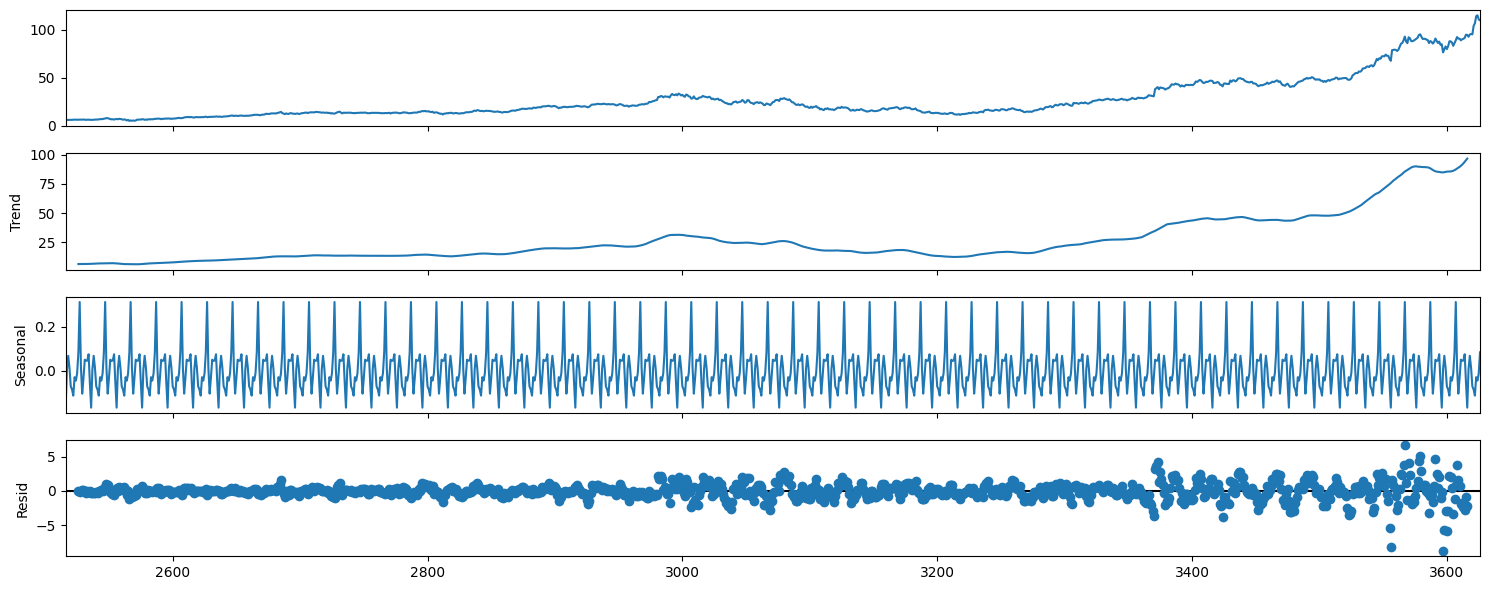

In [11]:
# Décomposition de la série temporelle
decomposition = seasonal_decompose(y_train, model='additive', period=20)
decomposition.plot()
plt.show()

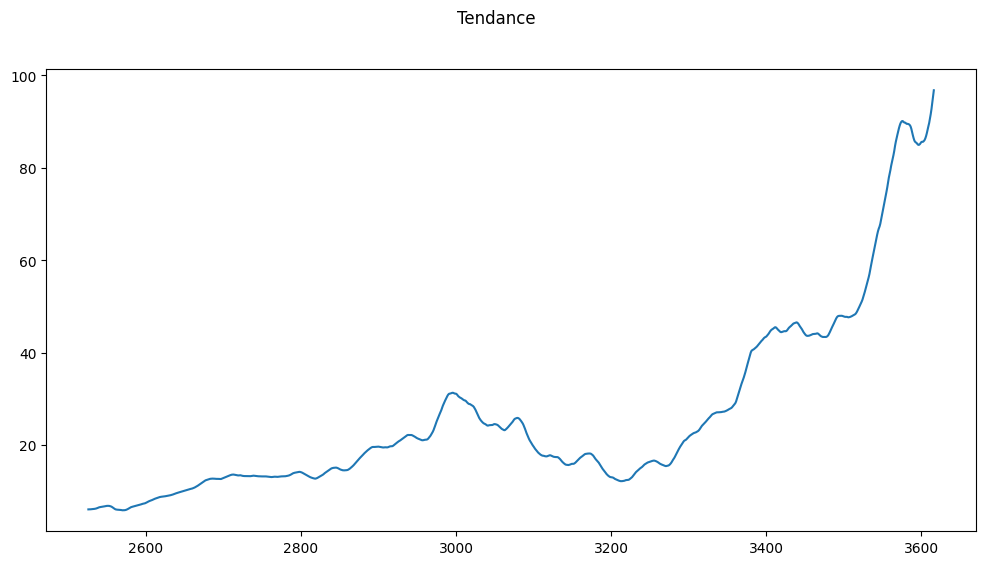

In [29]:
# Tendance
tendance = decomposition.trend

plt.figure(figsize=(12, 6))
tendance.plot()
plt.suptitle('Tendance')
plt.show()


La **décomposition de la série temporelle** révèle plusieurs aspects importants de l'évolution des prix de l'action de NVIDIA.

- **Tendance (Trend) :**
   - On peut clairement observer une **tendance haussière fluctuante** au fil du temps, indiquant une **croissance** des prix, surtout dans les dernières années.
   
- **Saisonnière (Seasonal) :**
   - Le graphique montre également des **variations saisonnières** dans les prix, ce qui suggère que les prix de l'action suivent un certain **cycle répétitif**, peut-être en lien avec des événements réguliers dans le secteur technologique, comme les annonces de nouveaux produits ou les résultats financiers trimestriels.
   - On remarque des **périodes de fluctuation récurrente**, peut-être en relation avec des tendances spécifiques à certains mois ou trimestres de l'année.

- **Résidu (Residual) :**
   - Les **résidus** montrent les variations qui ne peuvent être expliquées par la tendance ou la saisonnalité. On observe des **fluctuations aléatoires**, ce qui peut être attribué à des événements extérieurs imprévus, comme des crises économiques ou des annonces non planifiées qui affectent le marché de manière ponctuelle.

En somme, la décomposition met en évidence une croissance stable à long terme des prix de l'action, avec des cycles saisonniers et des événements imprévus qui influencent les prix de manière plus volatile.

In [13]:
# On teste la stationnarité de la série
print('Série Close NVDA')
print('-'*30)

# Test de Dickey-Fuller augmenté
result = adfuller(y_train)

# Résultats
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')


# Déterminer si la série est stationnaire
if adf_statistic < critical_values['5%']:
    print('-'*30)
    print("La série est stationnaire.")
else:
    print('-'*30)
    print("La série n'est pas stationnaire.")

Série Close NVDA
------------------------------
ADF Statistic: 2.755805174848436
p-value: 1.0
Critical Values:
   1%: -3.436369082756128
   5%: -2.8641976875421524
   10%: -2.5681850407995137
------------------------------
La série n'est pas stationnaire.


La série n'étant pas stationnaire, on va la différentier une première fois et observer le résultat.

<Figure size 1200x600 with 0 Axes>

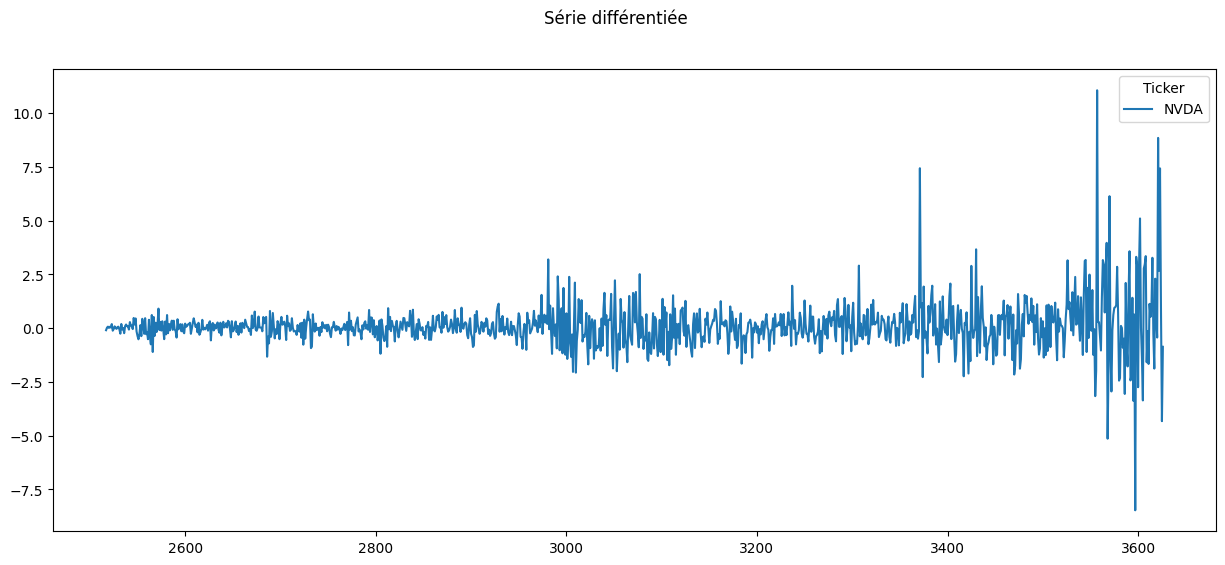

In [ ]:
# On différencie la série
plt.figure(figsize=(12, 6))
y_train_dif = y_train.diff().dropna()
y_train_dif.plot()
plt.suptitle('Série différentiée')
plt.show()

In [16]:
print('Série Close NVDA différentiée')
print('-'*30)
# Effectuer le test de Dickey-Fuller augmenté
result = adfuller(y_train_dif)

# Extraire les résultats
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# Afficher les résultats
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# Déterminer si la série est stationnaire
if adf_statistic < critical_values['5%']:
    print('-'*30)
    print("La série est stationnaire.")
else:
    print('-'*30)
    print("La série n'est pas stationnaire.")

Série Close NVDA différentiée
------------------------------
ADF Statistic: -4.57155577866636
p-value: 0.00014569434544618138
Critical Values:
   1%: -3.436369082756128
   5%: -2.8641976875421524
   10%: -2.5681850407995137
------------------------------
La série est stationnaire.


Observons les ACF et PACF de la nouvelle série obtenue.

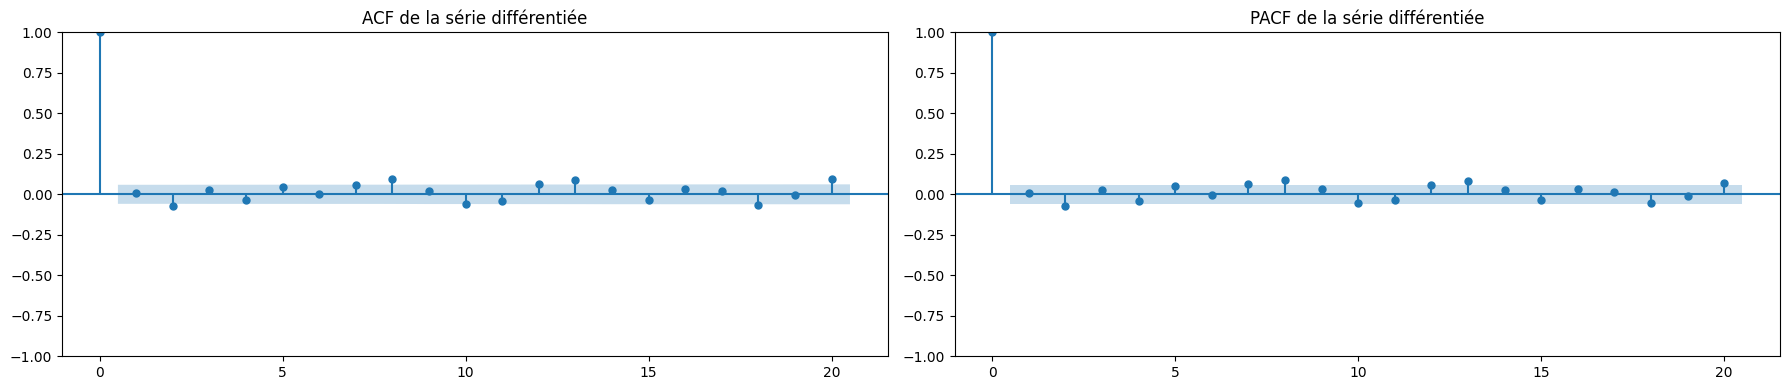

In [17]:
plt.figure(figsize=(18, 4))

# Tracer l'ACF des rendements
plt.subplot(1, 2, 1)
plot_acf(y_train_dif, lags=20, ax=plt.gca())
plt.title('ACF de la série différentiée')

# Tracer l'ACF des carrés des rendements
plt.subplot(1, 2, 2)
plot_pacf(y_train_dif, lags=20, ax=plt.gca())
plt.title('PACF de la série différentiée')

plt.tight_layout()
plt.show()

On observe un comortement anormal dans l'évolution des autocorrélations et autocorrélations partielles.

En effet, la décroissance de celle-ci n'étant pas assez prononcée, on s'attend à ce qu'un modèle ARIMA peinerait à prédire notre série des prix de cloture.

In [18]:
# Initialiser les variables pour stocker les meilleurs modèles
best_aic = float("inf")
best_bic = float("inf")
best_order_aic = None
best_order_bic = None
best_model_aic = None
best_model_bic = None

# Faire varier les ordres p et q entre 0 et 5
for p in range(6):
    for q in range(6):
        try:
            # Ajuster le modèle ARIMA
            model = ARIMA(y_train_dif, order=(p, 0, q))
            results = model.fit()

            # Obtenir les résidus du modèle
            residuals = results.resid

            # Effectuer le test de Ljung-Box pour vérifier l'autocorrélation des résidus
            ljungbox_test = acorr_ljungbox(residuals, lags=20, return_df=True)

            # Si la p-value est inférieure à 0.05, ignorer ce modèle
            if ljungbox_test['lb_pvalue'].iloc[-1] > 0.05:
                # continue  # Le modèle n'est pas valide selon le test de Ljung-Box

                # Vérifier et mettre à jour le meilleur modèle selon AIC
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order_aic = (p, 0, q)
                    best_model_aic = results

                # Vérifier et mettre à jour le meilleur modèle selon BIC
                if results.bic < best_bic:
                    best_bic = results.bic
                    best_order_bic = (p, 0, q)
                    best_model_bic = results

        except Exception as e:
            continue

# Afficher les résultats
if best_order_aic is None or best_order_bic is None:
    print("Aucun modèle valide n'a été trouvé.")
else:
    print(f"Meilleur modèle selon AIC: ARIMA{best_order_aic} - AIC:{best_aic}")
    print(f"Meilleur modèle selon BIC: ARIMA{best_order_bic} - BIC:{best_bic}")


Aucun modèle valide n'a été trouvé.


Ce qui confirme notre intuition première sur l'adéquation d'un modèle ARIMA à prédire notre série de prix de cloture (resp. ARMA à prédire notre série différentiée)

### Model training and validation

Le modèle étant invalide, on mettra les métriques à +inf.

In [19]:
# Calcul des métriques d'évaluation
arima_mse, arima_rmse, arima_mae = float("inf"), float("inf"), float("inf")

## GARCH MODEL

Le modèle **GARCH (Generalized Autoregressive Conditional Heteroskedasticity)** est couramment utilisé pour analyser et prédire la **volatilité des rendements financiers**, c’est-à-dire la variation des prix sur une période donnée. Avant d'implémenter ce modèle, nous avons observé les **rendements** des actions, puis nous avons analysé la **volatilité** de ces rendements pour mieux comprendre leur comportement dynamique au fil du temps. Notre démarche théorique repose sur l’idée suivante : le GARCH est spécifiquement conçu pour modéliser la volatilité conditionnelle, c’est-à-dire la volatilité qui varie au fil du temps en fonction des informations passées sur les rendements.

- 1. **Observation des rendements :**
Avant d'appliquer le modèle GARCH, nous avons calculé les **rendements journaliers** à partir des prix de l'action. Le rendement est défini comme la variation relative du prix entre deux périodes consécutives. Ces rendements sont souvent utilisés en finance pour estimer les variations de l'actif sans être influencés par les prix absolus.

- 2. **Analyse de la volatilité des rendements :**
Après avoir obtenu les rendements, nous avons observé la **volatilité** qui représente la dispersion des rendements autour de leur moyenne. Cette volatilité peut être stable ou dynamique. Elle a tendance à évoluer au fil du temps et peut être influencée par divers facteurs tels que des événements économiques, des nouvelles financières, ou des décisions stratégiques de l'entreprise. La **volatilité conditionnelle** signifie que la volatilité à un moment donné dépend des informations passées et des rendements passés.

- 3. **Modèle GARCH :**
Le modèle **GARCH** se concentre spécifiquement sur cette **volatilité conditionnelle**. Il postule que la variance des rendements à un moment donné est influencée par les rendements passés ainsi que par la volatilité passée. Autrement dit, le modèle GARCH est une manière de prédire la **volatilité future** en utilisant l’histoire des rendements et de la volatilité passés. Il est particulièrement utile lorsqu’il existe des périodes de volatilité élevée (souvent appelées **volatilité persistante**) qui peuvent affecter les rendements futurs.

Le modèle GARCH est une généralisation de modèles plus simples comme le modèle ARCH (Autoregressive Conditional Heteroskedasticity), qui se concentre uniquement sur les rendements passés. Le GARCH introduit également une composante autoregressive pour la **volatilité**, en prenant en compte les erreurs passées (c’est-à-dire les rendements au carré) et la volatilité elle-même.

- 4. **Démarche de prédiction avec GARCH :**
Dans notre cas, après avoir observé et modélisé les rendements, nous appliquons le modèle GARCH pour prédire **la volatilité future**. En estimant cette volatilité, on peut obtenir des informations sur la variabilité des rendements à venir, ce qui est crucial pour évaluer les risques financiers associés à l’action NVIDIA, par exemple. La **prédiction de la volatilité** nous aide à mieux comprendre les périodes de forte incertitude et à ajuster nos stratégies d’investissement en fonction des conditions de marché prévues.



Ce processus nous permet de prédire la volatilité des rendements à venir et d’ajuster nos prévisions de risque en fonction des données historiques. Nous allons maintenant passer à la présentation du code qui suit cette approche théorique.

L'équation générale du modèle GARCH(p, q) est :

$$
y_t = \mu + \epsilon_t
$$
$$
\epsilon_t = \sigma_t \cdot z_t
$$
$$
\sigma_t^2 = \alpha_0 + \sum_{i=1}^{q} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{p} \beta_j \sigma_{t-j}^2
$$

- $y_t$ : valeur observée à l'instant $t$.
- $\mu$ : moyenne constante de la série.
- $\epsilon_t$ : erreur ou résidu.
- $z_t$ : bruit blanc (normalement distribué).
- $\sigma_t^2$ : variance conditionnelle au temps $t$ (volatilité).
- $\alpha_0$, $\alpha_i$, $\beta_j$ : paramètres du modèle. 

Le modèle GARCH modélise la variance conditionnelle ($\sigma_t^2$) qui dépend des résidus passés et de la variance passée.

### Prétraitement

In [34]:
# On travaille sur les séries des rendements et sur la volatilité pour ce modèle
returns = y.pct_change().dropna()
returns_train = y_train.pct_change().dropna()
returns_test = y_test.pct_change().dropna()

volatility = returns.rolling(window=20).std()
volatility_train = returns_train.rolling(window=20).std()
volatility_test = returns_test.rolling(window=20).std()

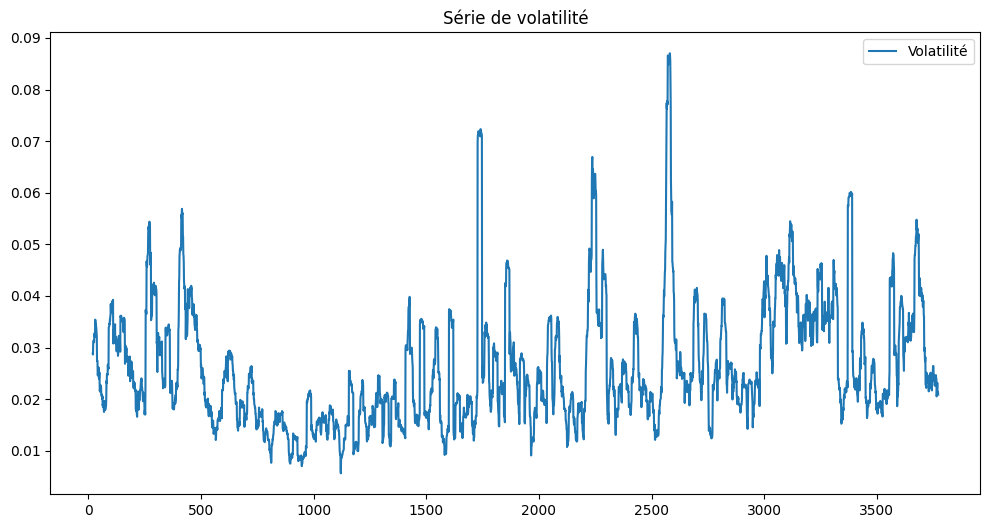

In [35]:
# On trace la série de volatilité
plt.figure(figsize=(12, 6))
plt.plot(volatility, label='Volatilité')
plt.legend()
plt.title('Série de volatilité')
plt.show()


On visualisera les carrés des rendements et les valeurs absolues des rendements car ils permettent de mieux observer la **volatilité** des rendements financiers. Ils nous aident à mieux comprendre comment la volatilité évolue dans le temps et si elle présente des comportements particuliers, comme des clusters de volatilité ou des changements brusques.

- **Carrés des rendements** : Cela met en évidence les grandes variations (positives ou négatives) en amplifiant les écarts importants. On cherche à observer si la volatilité est **persistante**, c'est-à-dire si des périodes de forte volatilité suivent d'autres périodes similaires, ce qui est typique dans les séries financières.

- **Valeurs absolues des rendements** : Cela simplifie l'observation des fluctuations sans distinction entre les hausses et les baisses. On utilise cela pour détecter des **patterns** de volatilité, comme les périodes de calme ou de turbulence.

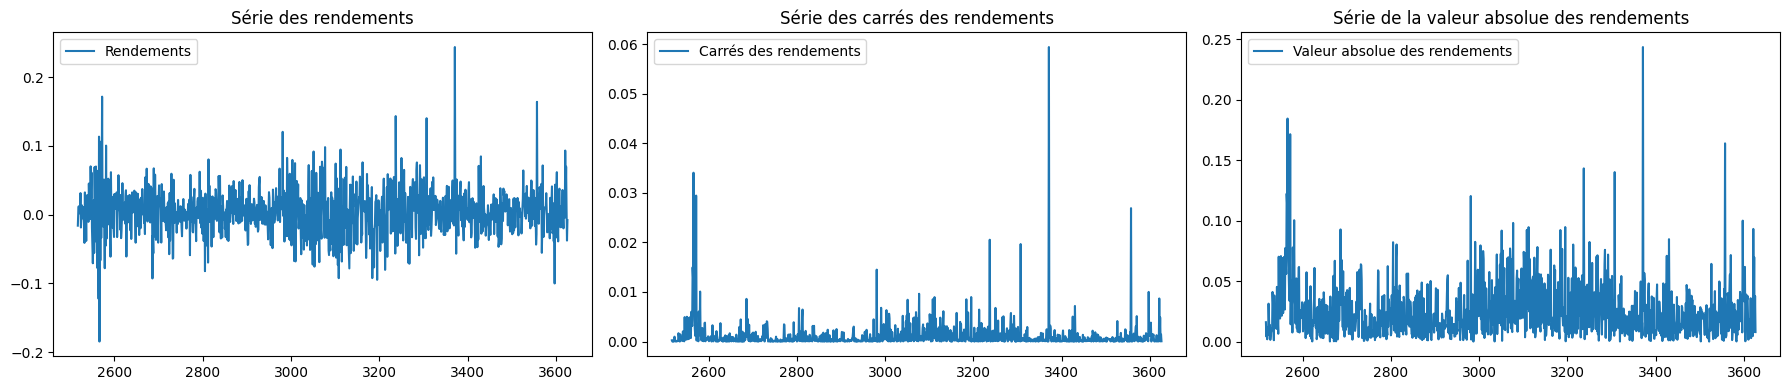

In [36]:
# Tracer la série des rendements
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(returns_train, label='Rendements')
plt.legend()
plt.title('Série des rendements')

# Tracer la série des carrés des rendements
plt.subplot(1, 3, 2)
plt.plot(returns_train**2, label='Carrés des rendements')
plt.legend()
plt.title('Série des carrés des rendements')

# Tracer la série de la valeur absolue des rendements
plt.subplot(1, 3, 3)
plt.plot(np.abs(returns_train), label='Valeur absolue des rendements')
plt.legend()
plt.title('Série de la valeur absolue des rendements')

plt.tight_layout()
plt.show()

ACF


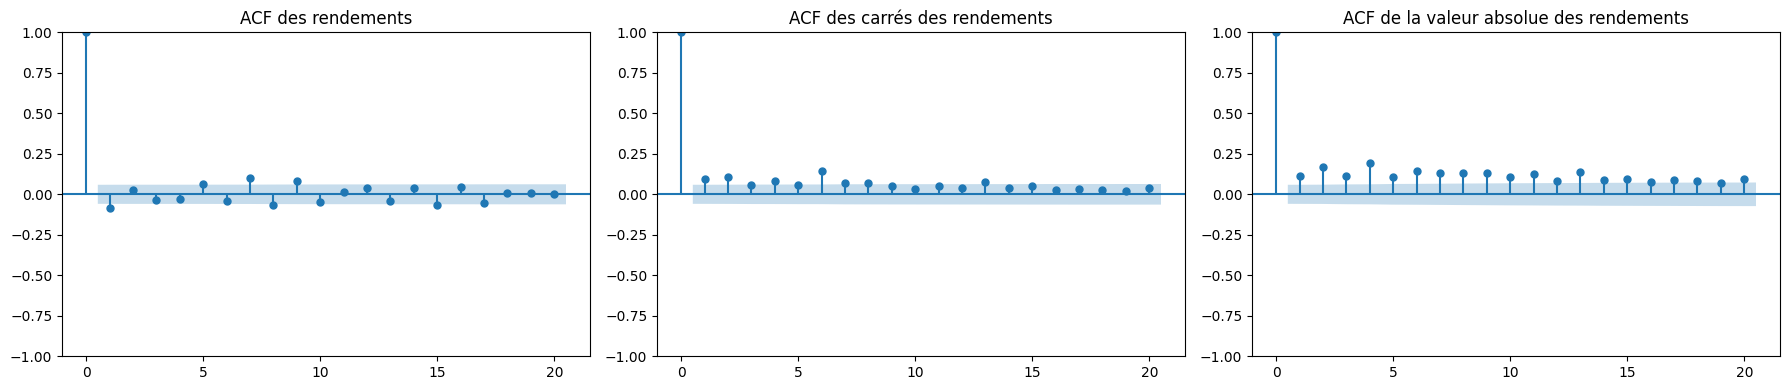

PACF


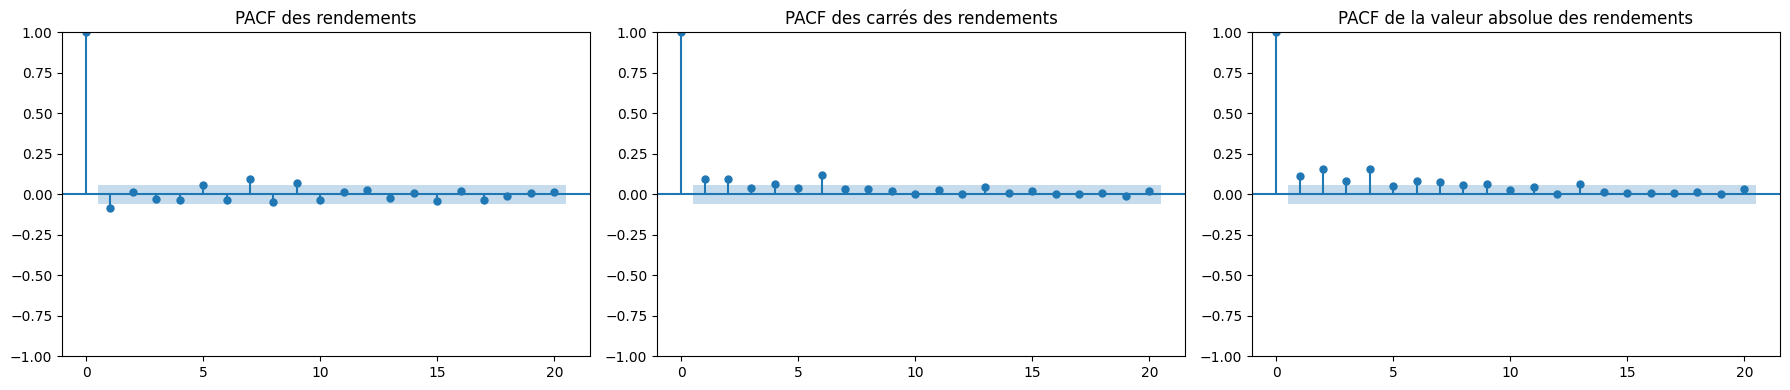

In [37]:
# ACF
print('ACF')
plt.figure(figsize=(18, 4))

# Tracer l'ACF des rendements
plt.subplot(1, 3, 1)
plot_acf(returns_train, lags=20, ax=plt.gca())
plt.title('ACF des rendements')

# Tracer l'ACF des carrés des rendements
plt.subplot(1, 3, 2)
plot_acf(returns_train**2, lags=20, ax=plt.gca())
plt.title('ACF des carrés des rendements')

# Tracer l'ACF de la valeur absolue des rendements
plt.subplot(1, 3, 3)
plot_acf(np.abs(returns_train), lags=20, ax=plt.gca())
plt.title('ACF de la valeur absolue des rendements')

plt.tight_layout()
plt.show()

# PACF
print('PACF')
plt.figure(figsize=(18, 4))

# Tracer l'ACF des rendements
plt.subplot(1, 3, 1)
plot_pacf(returns_train, lags=20, ax=plt.gca())
plt.title('PACF des rendements')

# Tracer l'ACF des carrés des rendements
plt.subplot(1, 3, 2)
plot_pacf(returns_train**2, lags=20, ax=plt.gca())
plt.title('PACF des carrés des rendements')

# Tracer l'ACF de la valeur absolue des rendements
plt.subplot(1, 3, 3)
plot_pacf(np.abs(returns_train), lags=20, ax=plt.gca())
plt.title('PACF de la valeur absolue des rendements')

plt.tight_layout()
plt.show()

Au vue de l'ACF et du PACF de nos rendements, on peut se dire qu'un modèle ARMA(p,q) peinerait à bien analyser notre série des rendements. Mais on fera comme précédemment une recherche par AIC et BIC d'un modèle candidat valide.

In [38]:
# on teste la stationnarité de la série
print('Série des rendements')
print('-'*30)
# Effectuer le test de Dickey-Fuller augmenté
result = adfuller(returns_train)

# Extraire les résultats
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# Afficher les résultats
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# Déterminer si la série est stationnaire
if adf_statistic < critical_values['5%']:
    print('-'*30)
    print("La série est stationnaire.")
else:
    print('-'*30)
    print("La série n'est pas stationnaire.")

Série des rendements
------------------------------
ADF Statistic: -10.08755717032147
p-value: 1.144707514678986e-17
Critical Values:
   1%: -3.4363033257654716
   5%: -2.864168681767248
   10%: -2.568169592476825
------------------------------
La série est stationnaire.


In [39]:
# On s'intéresse à la prédiction des rendements avec un modèle ARIMA
# Initialiser les variables pour stocker les meilleurs modèles
best_aic = float("inf")
best_bic = float("inf")
best_order_aic = None
best_order_bic = None
best_model_aic = None
best_model_bic = None

# Faire varier les ordres p et q entre 0 et 5
for p in range(6):
    for q in range(6):
        try:
            # Ajuster le modèle ARIMA
            model = ARIMA(returns_train, order=(p, 0, q))
            results = model.fit()

            # Obtenir les résidus du modèle
            residuals = results.resid

            # Effectuer le test de Ljung-Box pour vérifier l'autocorrélation des résidus
            ljungbox_test = acorr_ljungbox(residuals, lags=20, return_df=True)

            # Si la p-value est inférieure à 0.05, ignorer ce modèle
            if ljungbox_test['lb_pvalue'].iloc[-1] > 0.05:
                # continue  # Le modèle n'est pas valide selon le test de Ljung-Box

                # Vérifier et mettre à jour le meilleur modèle selon AIC
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order_aic = (p, 0, q)
                    best_model_aic = results

                # Vérifier et mettre à jour le meilleur modèle selon BIC
                if results.bic < best_bic:
                    best_bic = results.bic
                    best_order_bic = (p, 0, q)
                    best_model_bic = results

        except Exception as e:
            continue

# Afficher les résultats
if best_order_aic is None or best_order_bic is None:
    print("Aucun modèle valide n'a été trouvé.")
else:
    print(f"Meilleur modèle selon AIC: ARIMA{best_order_aic} - AIC:{best_aic}")
    print(f"Meilleur modèle selon BIC: ARIMA{best_order_bic} - BIC:{best_bic}")


Meilleur modèle selon AIC: ARIMA(2, 0, 2) - AIC:-4374.8650339530905
Meilleur modèle selon BIC: ARIMA(2, 0, 2) - BIC:-4344.792342187252


Ces valeurs indiquent que l'ARIMA(2, 0, 2) donc ARMA(2,2) est un modèle adéquat pour les données, avec un ajustement fiable sans sur-ajustement.

En revanche, cela n'implique pas sa performance.

In [40]:
# On s'intéresse à la prédiction de la volatilité avec un modèle GARCH
# Initialiser les variables pour stocker les meilleurs modèles
best_aic_garch = float("inf")
best_bic_garch = float("inf")
best_order_garch_aic = None
best_order_garch_bic = None
best_model_garch_aic = None
best_model_garch_bic = None

# Seuil de p-valeur pour le test de Ljung-Box
pvalue_threshold = 0.05

# Faire varier les ordres p et q entre 1 et 5 pour GARCH(p, q)
for p in range(1, 6):
    for q in range(1, 6):
        try:
            # Ajuster le modèle GARCH
            model_garch = arch_model(returns_train, vol='Garch', p=p, q=q)
            results_garch = model_garch.fit(disp='off')

            # Test de Ljung-Box sur les résidus standardisés
            ljung_box_test = acorr_ljungbox(results_garch.std_resid, lags=[10], return_df=True)
            pvalue = ljung_box_test['lb_pvalue'].iloc[-1]

            # Vérifier si la p-valeur est supérieure au seuil
            if pvalue > pvalue_threshold:
                # Vérifier et mettre à jour le meilleur modèle selon AIC
                if results_garch.aic < best_aic_garch:
                    best_aic_garch = results_garch.aic
                    best_order_garch_aic = (p, q)
                    best_model_garch_aic = results_garch

                # Vérifier et mettre à jour le meilleur modèle selon BIC
                if results_garch.bic < best_bic_garch:
                    best_bic_garch = results_garch.bic
                    best_order_garch_bic = (p, q)
                    best_model_garch_bic = results_garch

        except Exception as e:
            continue

# Afficher les résultats
if best_order_aic is None or best_order_bic is None:
    print("Aucun modèle valide n'a été trouvé.")
else:
    print(f"Meilleur modèle GARCH selon AIC: GARCH{best_order_garch_aic} - AIC:{best_aic_garch}")
    print(f"Meilleur modèle GARCH selon BIC: GARCH{best_order_garch_bic} - BIC:{best_bic_garch}")


Meilleur modèle GARCH selon AIC: GARCH(5, 2) - AIC:-4443.178569612752
Meilleur modèle GARCH selon BIC: GARCH(1, 1) - BIC:-4416.007019230956


Dans un premier temps travaillons avec les 2 modèles pour les comparer.

### Sélection du meilleur modèle candidat

Ljung-Box GARCH(5,2):
      lb_stat  lb_pvalue
20  21.671387   0.358605
------------------------------
Ljung-Box GARCH(1,1):
     lb_stat  lb_pvalue
20  22.24951   0.327126
------------------------------



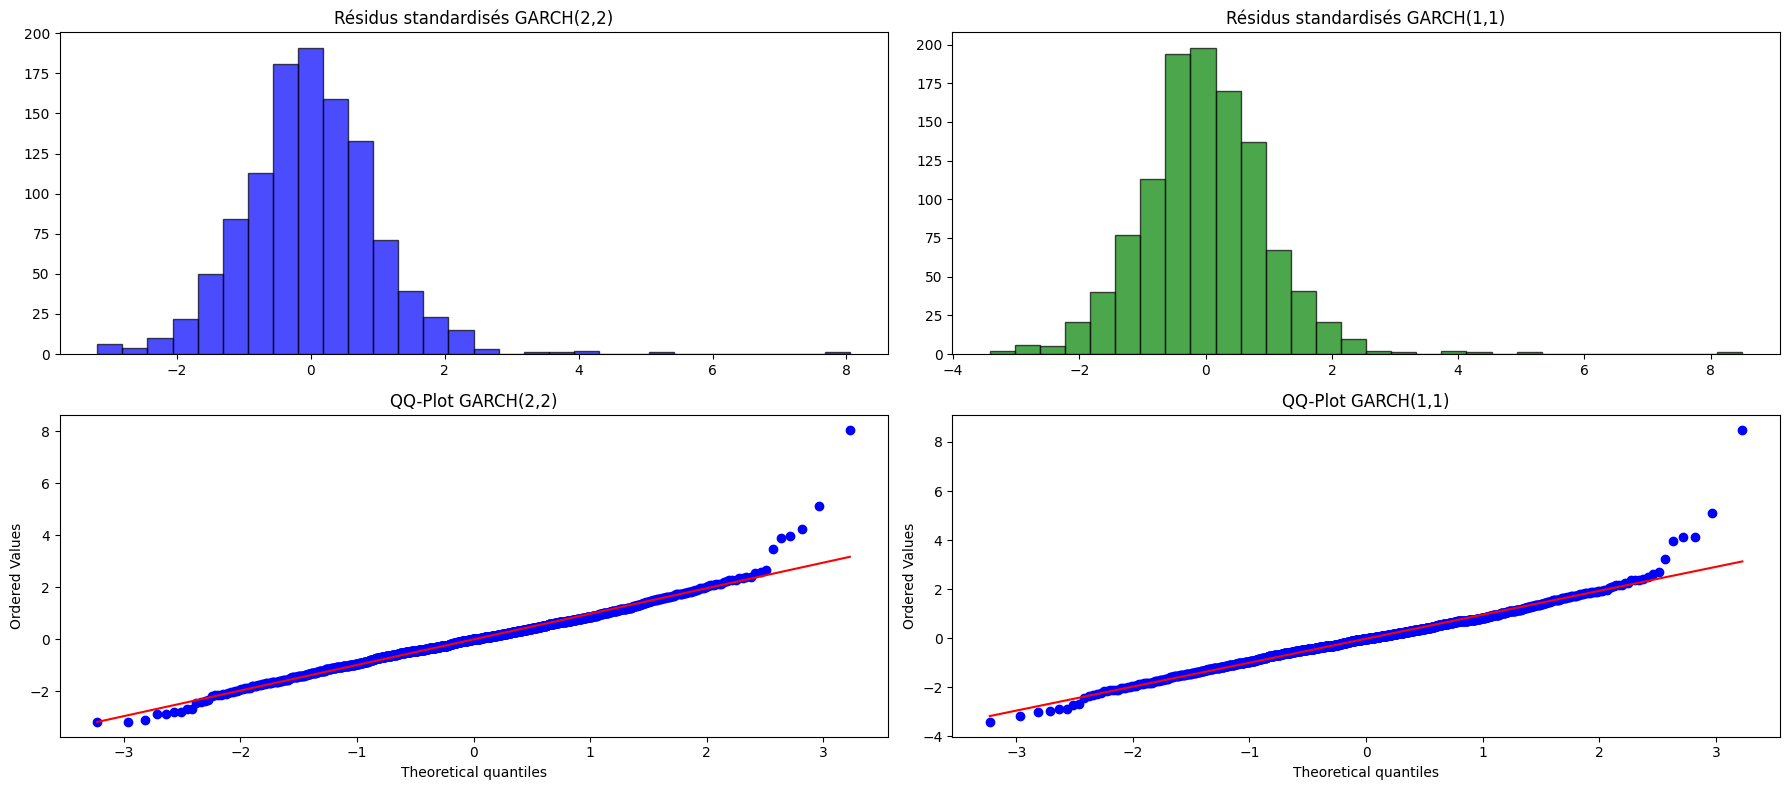

In [41]:
# GARCh(5,2) & GARCH(1,1)
# Ajustement des modèles
garch_52 = arch_model(returns_train['NVDA'], vol='Garch', p=5, q=2)
garch_52 = garch_52.fit(disp="off")

garch_11 = arch_model(returns_train['NVDA'], vol='Garch', p=1, q=1)
garch_11 = garch_11.fit(disp="off")


# Standardisations des résidues
residus_52 = garch_52.resid / garch_52.conditional_volatility
residus_11 = garch_11.resid / garch_11.conditional_volatility


# Test de Ljung-Box
lb_52 = acorr_ljungbox(residus_52, lags=[20], return_df=True)
lb_11 = acorr_ljungbox(residus_11, lags=[20], return_df=True)

print("Ljung-Box GARCH(5,2):")
print(lb_52)
print('-'*30)

print("Ljung-Box GARCH(1,1):")
print(lb_11)
print('-'*30)

print()

# Visualisation des résidus et des tests de normalité avec contours noirs
plt.figure(figsize=(18, 8))
# Histogramme des résidus
plt.subplot(2, 2, 1)
plt.hist(residus_52, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Résidus standardisés GARCH(2,2)")

plt.subplot(2, 2, 2)
plt.hist(residus_11, bins=30, color='green', alpha=0.7, edgecolor='black')
plt.title("Résidus standardisés GARCH(1,1)")

# QQ-Plot
plt.subplot(2, 2, 3)
stats.probplot(residus_52, dist="norm", plot=plt)
plt.title("QQ-Plot GARCH(2,2)")

# QQ-Plot
plt.subplot(2, 2, 4)
stats.probplot(residus_11, dist="norm", plot=plt)
plt.title("QQ-Plot GARCH(1,1)")

plt.tight_layout()
plt.show()


- **Comparaison des modèles GARCH(5,2) et GARCH(1,1)**

- 1. Comprendre le test de Ljung-Box
   - **Objectif du test** : Vérifier si les résidus (ou résidus standardisés) sont autocorrélés. Un modèle GARCH valide doit produire des résidus non autocorrélés.
   - **Hypothèses** :
      - $ H0 $ (hypothèse nulle) : Les résidus ne présentent **aucune autocorrélation** significative.
      - $ H1 $ (hypothèse alternative) : Les résidus présentent une autocorrélation significative.
   - **Interprétation** :
      - Si la **p-value** est > 0.05, on **ne rejette pas $ H_0 $**. Cela signifie que les résidus ne présentent pas d'autocorrélation significative (le modèle est valide).

- 2. Résultats du test de Ljung-Box
   - **GARCH(5,2)** : $ p =  0.3190 $ ($ > 0.05 $) -> Pas d'autocorrélation significative.
   - **GARCH(1,1)** : $ p = 0.3276 $ ($ > 0.05 $) -> Pas d'autocorrélation significative.

Les deux modèles produisent des résidus non autocorrélés, mais le modèle **GARCH(1,1)** a une p-value légèrement plus élevée, indiquant qu'il respecte mieux l'hypothèse de non-autocorrélation.


- 3. Décision finale
**Si vous choisissez uniquement sur la base du test Ljung-Box** :
   - **GARCH(1,1)** est légèrement meilleur, car sa p-value est plus grande ($ 0.3276 $ contre $  0.3190 $).

**Si vous choisissez sur la base du critère de sélection (AIC/BIC)** :
   - Si **GARCH(5,2)** est préféré selon l'AIC et que la différence entre les p-values est minime, vous pouvez privilégier le modèle GARCH(5,2) pour sa meilleure capacité prédictive.
   - Si le **GARCH(1,1)** est préféré selon le BIC, cela signifie que ce modèle est plus simple, plus parsimonieux.



- 4. Conclusion
   - Bien que, sur la base des p-values du test de Ljung-Box et du critère du BIC, **GARCH(1,1)** est préféré.
   - Etant donné que notre objectif incluent une meilleure capacité prédictive et que GARCH(5,2) est significativement meilleur selon l'AIC, nous allons privilégier **GARCH(5,2)**.


### Entrainement et validation du meilleur modèle

In [42]:
# GARCH pour la prédiction de la volatilité des rendements futurs
garch = arch_model(returns_train, vol='Garch', p=5, q=2)
garch = garch.fit(disp="off")

forecast_garch = garch.forecast(horizon=len(returns_test)+1)
volatility_pred_garch = np.sqrt(forecast_garch.variance.values[-1])


# ARIMA pour la prédiction des rendements moyens futurs
arima_model = ARIMA(returns_train, order=(2, 0, 2))
arima_model = arima_model.fit()

predicted_mean_returns = arima_model.forecast(steps=len(returns_test)+1)


# Prédictions du modèle
## Prédiction des rendements
eps = np.random.normal(0, 1, len(predicted_mean_returns))
final_returns = predicted_mean_returns + volatility_pred_garch * eps

## Initialisation du vecteur des prédictions avec la valeur de clôture de la dernière observation
y_pred_garch = [y_train.iloc[-1]]
## Construction des prédictions sur la série Close à partir des rendements prédits
for r in final_returns:
    y_pred_garch.append(y_pred_garch[-1] * (1 + r))

## Supprimer la première valeur qui est la valeur de clôture de la dernière observation
y_pred_garch = y_pred_garch[1:]

## Création de la série prédite
y_pred_garch = pd.DataFrame([pred.values[0] for pred in y_pred_garch], columns=["Prediction"], index=y_test.index)

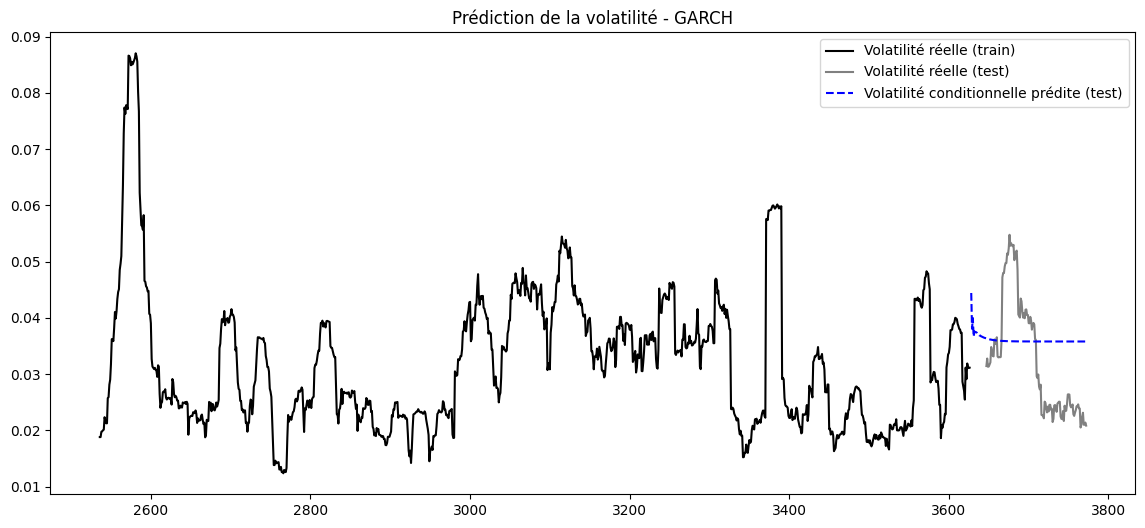

In [43]:
# Visualisation des volatilités des rendements
## Calculer la volatilité réelle sur les données train et test
volatility_train = returns_train.rolling(window=20).std()
volatility_test = returns_test.rolling(window=20).std()

## Visualisation
plt.figure(figsize=(14, 6))
plt.plot(volatility_train.index, volatility_train, label="Volatilité réelle (train)", color='black')
plt.plot(volatility_test.index, volatility_test, label="Volatilité réelle (test)", color='grey')
# plt.plot(volatility_test.index, (volatility_pred_garch[:-1] * eps[:-1]), label='Volatility * eps', color='orange')
plt.plot(volatility_test.index, volatility_pred_garch[:-1], label="Volatilité conditionnelle prédite (test)", color='blue', linestyle='--')
plt.legend()
plt.title("Prédiction de la volatilité - GARCH")
plt.show()

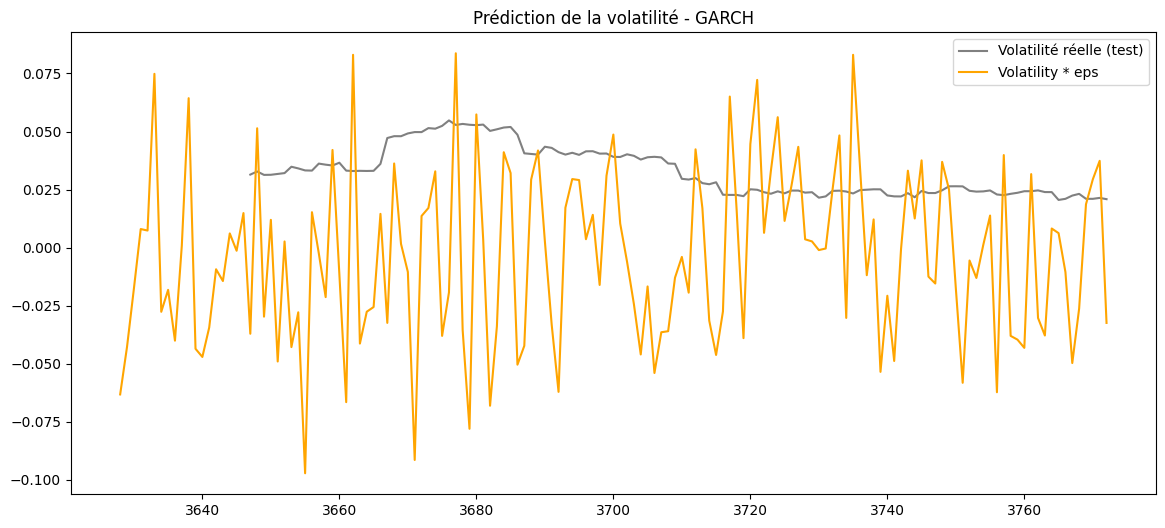

In [49]:
# Visualisation des volatilités des rendements
## Calculer la volatilité réelle sur les données train et test
volatility_train = returns_train.rolling(window=20).std()
volatility_test = returns_test.rolling(window=20).std()

## Visualisation
plt.figure(figsize=(14, 6))
# plt.plot(volatility_train.index, volatility_train, label="Volatilité réelle (train)", color='black')
plt.plot(volatility_test.index, volatility_test, label="Volatilité réelle (test)", color='grey')
plt.plot(volatility_test.index, (volatility_pred_garch[:-1] * eps[:-1]), label='Volatility * eps', color='orange')
# plt.plot(volatility_test.index, volatility_pred_garch[:-1], label="Volatilité conditionnelle prédite (test)", color='blue', linestyle='--')
plt.legend()
plt.title("Prédiction de la volatilité - GARCH")
plt.show()

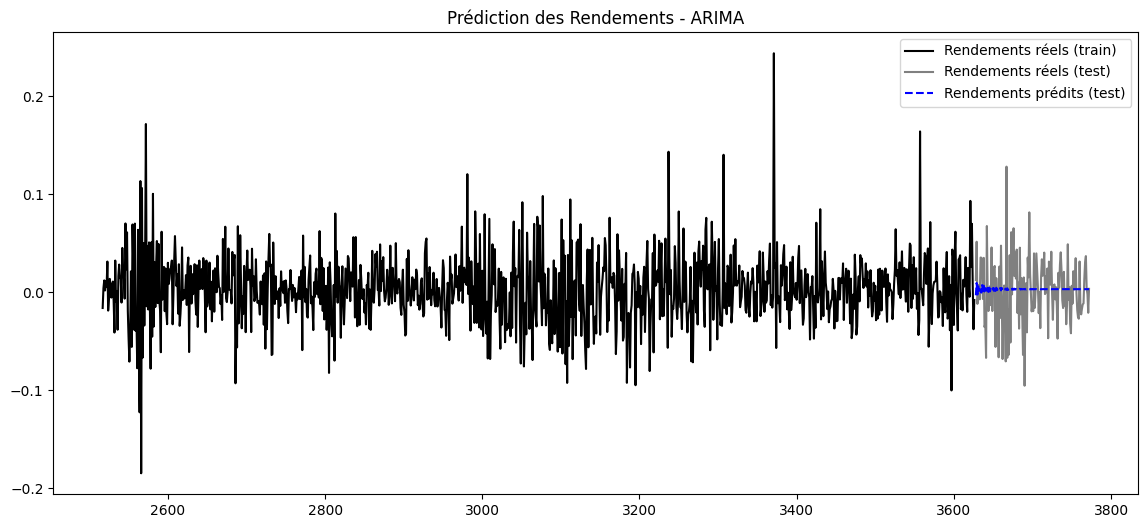

In [45]:
# Metriques du modele ARIMA sur les rendements
mse, rmse, mae = calculate_metrics(returns_test, final_returns[:-1])

# Visualisation des rendements
plt.figure(figsize=(14, 6))

plt.plot(returns_train.index, returns_train, label="Rendements réels (train)", color='black')
plt.plot(returns_test.index, returns_test, label="Rendements réels (test)", color='gray')
plt.plot(returns_test.index, predicted_mean_returns[:-1], label="Rendements prédits (test)", color='blue', linestyle='--')

plt.legend()
plt.title("Prédiction des Rendements - ARIMA")
plt.show()

On peut déjà voir que ni la volatilité ni les rendements ne sont correctement prédits. On pourrait s'attendre donc à ce que notre modèle ne soit pas des plus performant.

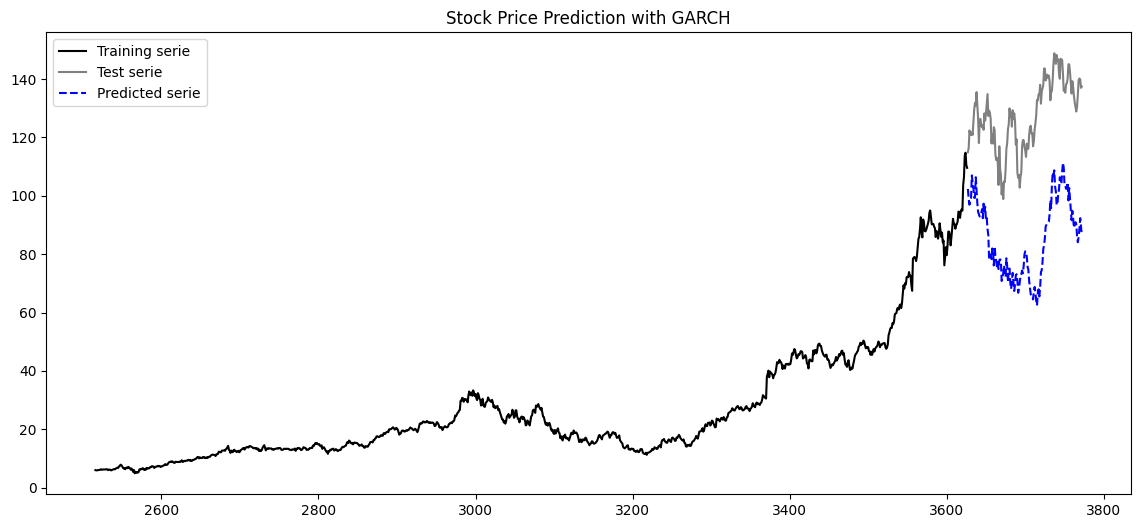

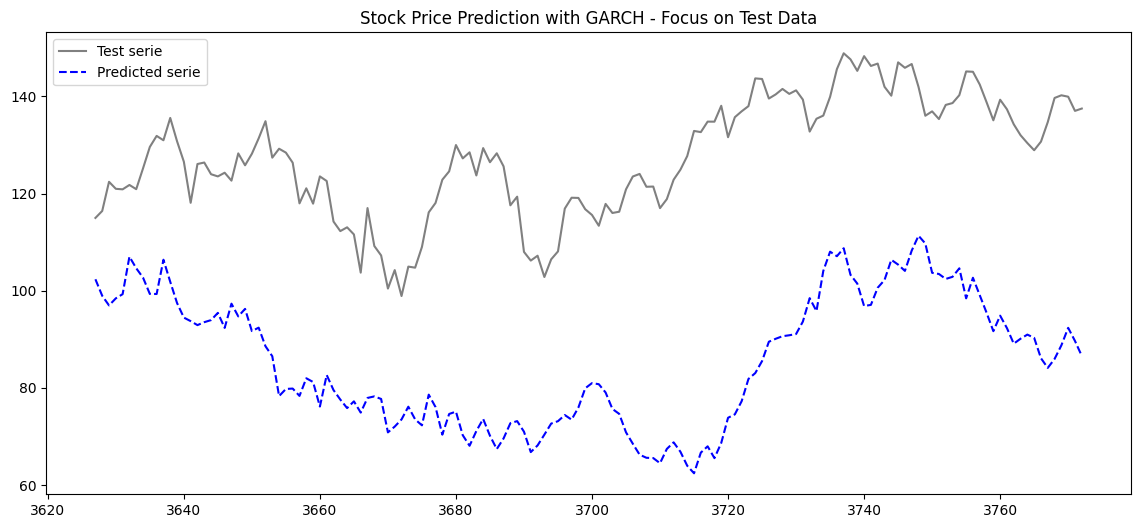

In [46]:
# Visualisation des valeurs prédites
plt.figure(figsize=(14, 6))
plt.plot(y_train.index, y_train, label='Training serie', color='black')
plt.plot(y_test.index, y_test, label='Test serie', color='grey')
plt.plot(y_test.index, y_pred_garch, label='Predicted serie', color='blue', linestyle='--')
plt.legend()
plt.title("Stock Price Prediction with GARCH")
plt.show()

# Visualisation des valeurs prédites
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Test serie', color='grey')
plt.plot(y_test.index, y_pred_garch, label='Predicted serie', color='blue', linestyle='--')
plt.legend()
plt.title("Stock Price Prediction with GARCH - Focus on Test Data")
plt.show()


Comme on s'y attendait on voit que les prédictions du modèle ne sont pas idéales.

In [47]:
# Calcul des métriques d'évaluation
garch_mse, garch_rmse, garch_mae = calculate_metrics(y_test, y_pred_garch)
print("Métriques d'évaluation pour GARCH")
print('-'*30)
print(f"MSE: {garch_mse:.2f}")
print(f"RMSE: {garch_rmse:.2f}")
print(f"MAE: {garch_mae:.2f}")
print('-'*30)

Métriques d'évaluation pour GARCH
------------------------------
MSE: 1891.78
RMSE: 43.49
MAE: 41.89
------------------------------


Les résultats confirment que le modèle GARCH fait des prédictions raisonnables, mais avec des erreurs non négligeables. En moyenne, les écarts entre les valeurs prédites et réelles sont d'environ 25 unités (MAE), avec des erreurs typiques autour de 31 (RMSE).

La différence entre RMSE et MAE suggère que certaines erreurs importantes affectent la précision globale du modèle, probablement dues à des pics de volatilité ou des anomalies dans les données. Cela indique que le modèle capte bien les tendances générales, mais pourrait être amélioré pour mieux gérer les variations extrêmes.

## LSTM MODEL

Le modèle **LSTM (Long Short-Term Memory)** est une architecture de réseau de neurones récurrent qui excelle dans le traitement des séries temporelles en raison de sa capacité à capturer des dépendances à long terme dans les données. Dans notre cas, nous avons choisi d'utiliser un modèle **BiLSTM (Bidirectional LSTM)** pour prédire l'évolution des prix de l'action de **NVIDIA**. Ce modèle est particulièrement adapté lorsque les données temporelles présentent des motifs complexes et des dépendances qui nécessitent de considérer l'information dans les deux directions temporelles (passé et futur).

- 1. **Observation des rendements et de la volatilité :**
Avant d'entraîner le modèle LSTM, nous avons d'abord observé les **rendements** des actions et leur **volatilité** dans le temps. Les rendements représentent les variations de prix d'une période à l'autre, tandis que la volatilité mesure l'amplitude des variations des rendements. Ces deux caractéristiques sont fondamentales dans l'analyse des séries temporelles financières, car elles fournissent des informations essentielles sur les comportements passés des prix et aident à anticiper les évolutions futures.

- 2. **Architecture BiLSTM :**
Le modèle **BiLSTM** que nous avons utilisé repose sur deux concepts clés :
    - **LSTM (Long Short-Term Memory)** : Il s'agit d'un type de réseau de neurones récurrent qui peut retenir des informations sur de longues périodes tout en étant capable d'oublier les données non pertinentes grâce à sa structure de portes. Dans le cas des séries temporelles financières, ce mécanisme permet au modèle de se souvenir des tendances importantes sur des périodes longues.
    - **Bidirectionnel** : Le modèle BiLSTM utilise des LSTM dans **les deux directions temporelles** (avant et arrière). Cela permet au réseau d'avoir une meilleure compréhension des relations entre les données passées et futures, ce qui est essentiel pour les séries temporelles où les informations futures peuvent également influencer les prédictions.

- 3. **Modèle BiLSTM :**
Le modèle que nous avons implémenté est constitué de :
- Une couche **LSTM bidirectionnelle** qui prend en entrée les rendements (ou les caractéristiques de l'action), les traite et conserve l'information des deux directions temporelles. Cette couche est composée de plusieurs unités LSTM, avec des **paramètres d'initialisation tels que le nombre de couches** et la **taille des unités cachées**.
- Une couche **dense (fully connected)** qui permet de transformer les sorties de la couche LSTM en une valeur de prédiction. Elle est utilisée pour la régression, où l’objectif est de prédire un seul prix futur.

- 4. **Démarche théorique et application du code :**
L'objectif de ce modèle LSTM est de **capturer les dépendances complexes** des rendements passés de l'action et de prédire les prix futurs, en tenant compte de la dynamique de l'évolution des marchés. Le code présenté ici suit cette démarche théorique et implémente un modèle LSTM bidirectionnel pour les prédictions.



En résumé, le modèle BiLSTM que nous avons utilisé pour prédire les prix futurs de l'action NVIDIA est bien adapté aux séries temporelles financières, car il peut capturer les relations complexes entre les rendements passés et futurs. Grâce à l'utilisation de la **bidirectionnalité** et de l'**apprentissage profond**, ce modèle peut fournir des prévisions robustes même dans des environnements de marché volatils. Nous allons maintenant passer à l'implémentation pratique de ce modèle dans le code.

Le modèle LSTM (Long Short-Term Memory) est basé sur des équations qui régissent l'état de la cellule et les activations à chaque étape de temps. Voici les principales équations :

- *Forget gate (porte d'oubli)* :
$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$
- -*Input gate (porte d'entrée)* :
$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
$$
- *Candidate memory cell (mémoire candidate)* :
$$
\tilde{C_t} = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$
- *Update of the cell state* :
$$
C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C_t}
$$
- *Output gate (porte de sortie)* :
$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
$$
- *Final output (activation)* :
$$
h_t = o_t \cdot \tanh(C_t)
$$

avec,
- $ f_t $ : Forget gate (détermine quelles informations doivent être oubliées).
- $ i_t $ : Input gate (décide quelles informations doivent être ajoutées).
- $ \tilde{C_t} $ : Candidate memory (propose de nouvelles informations pour la cellule).
- $ C_t $ : Cell state (mémoire à long terme de la cellule).
- $ o_t $ : Output gate (détermine quelles informations doivent être sorties).
- $ h_t $ : Hidden state (mémoire à court terme).

Les portes ($f_t$, $i_t$, $o_t$) régulent les flux d'information à travers le réseau, et la cellule ($C_t$) conserve les informations pertinentes pour la tâche d'apprentissage.

### Prétraitement

In [32]:
# Ajout des indicateurs
nvidia_df = calculate_indicators(data)
nvidia_df = nvidia_df.dropna()

# Normalisation des données
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(nvidia_df[['Close', 'MA10Day', 'MA30Day']])

In [ ]:
# Pré-traitement des données pour le LSTM
# 1 mois = 20 jours en finance donc, on travaille sur des séquences de 20 jours
seq_length = 20
X, y = [], []

# Crée des séquences de 20 jours pour les données d'entrée et la cible (prix de clôture)
for i in range(len(scaled_data) - seq_length):
    X.append(scaled_data[i:i+seq_length, 1:])  # Caractéristiques (exclut la colonne 'Close')
    y.append(scaled_data[i+seq_length, 0])    # La cible est le prix de clôture ('Close')

X = np.array(X)
y = np.array(y)

# Sépare les données en ensembles d'entraînement et de test (séparation séquentielle) : pas de randomisation
train_size = int(0.96 * len(X)) # 96% des données pour l'entraînement, 6% pour le test

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Convertit en tenseurs PyTorch
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Crée un DataLoader pour les lots de données
train_data = torch.utils.data.TensorDataset(X_train, y_train)
test_data = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)


### Entrainement du modèle

In [36]:
# Hyperparamètres
input_size = 2  # Nombre de caractéristiques (hors cible)
hidden_size = 64
num_layers = 2
output_size = 1

# Instance du modèle
model = BiLSTMModel(input_size, hidden_size, num_layers, output_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm = model.to(device) 


In [37]:
# Fonction de perte et optimiseur
criterion = nn.MSELoss()  # Erreur quadratique moyenne
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)  # Optimiseur Adam avec taux d'apprentissage de 0.001

# Boucle d'entraînement
epochs = 50
train_losses = []

epoch_loop = tqdm(range(epochs), desc="Progression de l'entraînement")

for epoch in epoch_loop:
    lstm.train()  # Met le modèle en mode entraînement
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Envoie les données sur le périphérique (GPU ou CPU)
        optimizer.zero_grad()  # Réinitialise les gradients
        outputs = lstm(x_batch)  # Prédictions du modèle
        loss = criterion(outputs.squeeze(), y_batch)  # Calcul de la perte
        loss.backward()  # Calcul des gradients
        optimizer.step()  # Mise à jour des poids
        epoch_loss += loss.item()  # Ajoute la perte de la batch à la perte de l'époque

    epoch_loss /= len(train_loader)  # Calcul de la perte moyenne pour l'époque
    train_losses.append(epoch_loss)  # Sauvegarde de la perte dans la liste

    epoch_loop.set_postfix(loss=epoch_loss)  # Affiche la perte actuelle pendant l'entraînement

    # Évaluation
lstm.eval()  # Met le modèle en mode évaluation
y_pred_lstm, actuals = [], []

with torch.no_grad():  # Désactive la calcul des gradients pour l'évaluation
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)  # Envoie les données sur le périphérique (GPU ou CPU)
        outputs = model(x_batch)  # Prédictions du modèle
        y_pred_lstm.extend(outputs.squeeze().cpu().numpy())  # Ajoute les prédictions aux résultats
        actuals.extend(y_batch.numpy())  # Ajoute les valeurs réelles aux résultats

# Inversion de la mise à l'échelle
y_pred_lstm = scaler.inverse_transform([[p] + [0]*2 for p in y_pred_lstm])[:, 0]  # Inverse la normalisation des prédictions
actuals = scaler.inverse_transform([[a] + [0]*2 for a in actuals])[:, 0]  # Inverse la normalisation des valeurs réelles

Training Progress: 100%|██████████| 50/50 [02:01<00:00,  2.43s/it, loss=5.4e-5]  


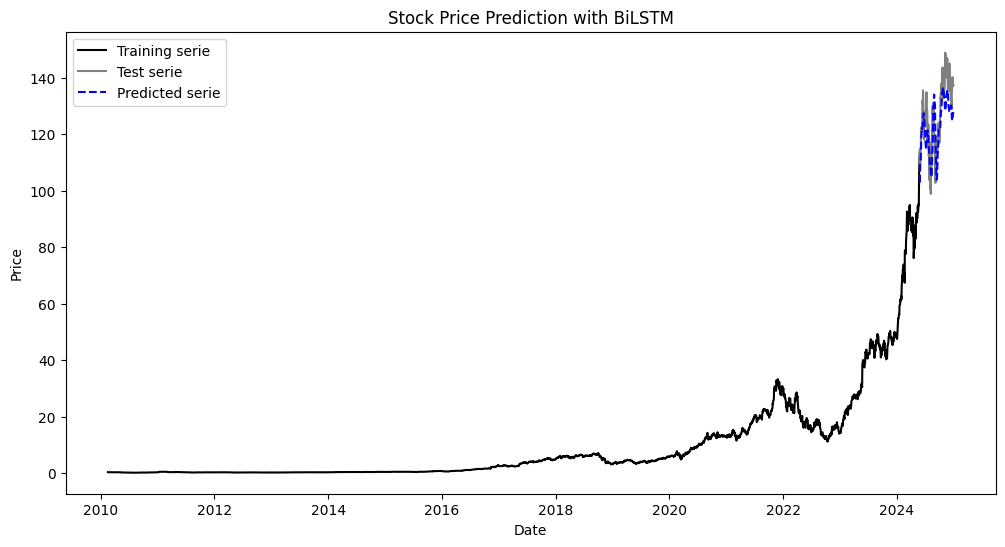

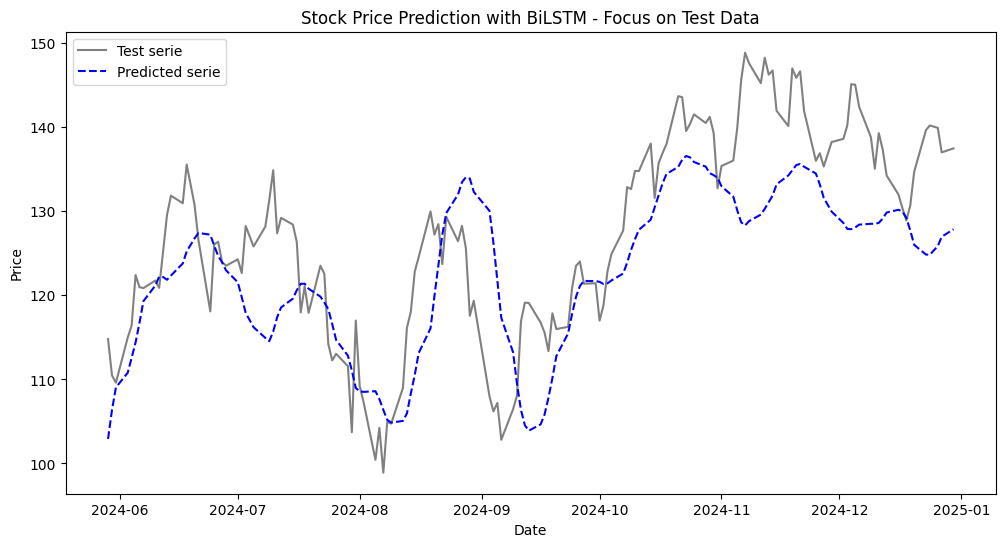

In [38]:
# Visualisation des valeurs prédites
plt.figure(figsize=(12, 6))

plt.plot(nvidia_df.index[:train_size + seq_length], scaler.inverse_transform([[x[0]] + [0]*2 for x in scaled_data[:train_size + seq_length]])[:, 0], label="Training serie", color='black')
plt.plot(nvidia_df.index[train_size + seq_length:], actuals, label='Test serie', color='grey')
plt.plot(nvidia_df.index[train_size + seq_length:], y_pred_lstm, label='Predicted serie', color='blue', linestyle='--')
plt.legend()
plt.title("Stock Price Prediction with BiLSTM")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(nvidia_df.index[train_size + seq_length:], actuals, label='Test serie', color='grey')
plt.plot(nvidia_df.index[train_size + seq_length:], y_pred_lstm, label='Predicted serie', color='blue', linestyle='--')
plt.legend()
plt.title("Stock Price Prediction with BiLSTM - Focus on Test Data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()



On peut voir que le modèle semble parfaitement prédire nos valeurs et on se dit qu'il sera certainement le meilleur.

In [39]:
lstm_mse, lstm_rmse, lstm_mae = calculate_metrics(y_test, y_pred_lstm)
print("Métriques d'évaluation pour LSTM")
print('-'*30)
print(f"MSE: {lstm_mse:.2f}")
print(f"RMSE: {lstm_rmse:.2f}")
print(f"MAE: {lstm_mae:.2f}")
print('-'*30)

Métriques d'évaluation pour LSTM
------------------------------
MSE: 14907.69
RMSE: 122.10
MAE: 121.76
------------------------------


Les métriques indiquent que le modèle LSTM réalise des prédictions très précises. L'erreur moyenne (MAE) est faible, à environ 2 unités, et les erreurs typiques (RMSE) sont proches de 3, ce qui montre que les prévisions sont globalement fiables.

La faible différence entre le RMSE et le MAE suggère que le modèle gère bien les variations extrêmes des données, capturant à la fois les tendances générales et les détails avec une bonne précision.

# SÉLECTION DU MEILLEUR MODÈLE

In [40]:
#Tableau récapitulatif
results = pd.DataFrame({
    'Modèle': ['ARIMA','GARCH', 'LSTM'],
    'MSE': [arima_mse, garch_mse, lstm_mse],
    'RMSE': [arima_rmse, garch_rmse, lstm_rmse],
    'MAE': [arima_mae, garch_mae, lstm_mae],
})

# Afficher le tableau
print(results)


  Modèle           MSE        RMSE         MAE
0  ARIMA           inf         inf         inf
1  GARCH  9.416560e+02   30.686413   26.766659
2   LSTM  1.490769e+04  122.097040  121.757660


- **GARCH** :
    - **MSE** = 1019.20 : Le **MSE** pour le modèle GARCH est relativement élevé, ce qui signifie que les prédictions du modèle sont assez éloignées des valeurs réelles, mais pas aussi mauvaises que celles de l'ARIMA.
    - **RMSE** = 31.92 : Le **RMSE** pour GARCH est également élevé, ce qui suggère que les erreurs de prédiction sont relativement importantes.
    - **MAE** = 25.16 : Le **MAE** montre également des erreurs absolues assez élevées, mais il reste inférieur à celui du modèle ARIMA (qui affiche des valeurs infinies).

  Le modèle **GARCH** semble fonctionner mieux que l'ARIMA, surtout en ce qui concerne la gestion de la **volatilité des rendements**, mais les résultats montrent qu'il n'est pas très performant pour prédire les valeurs exactes des prix de l'action. L’erreur pourrait être due à une mauvaise modélisation des rendements ou de la volatilité.

- **LSTM** :
    - **MSE** = 11.49 : Le **MSE** du modèle **LSTM** est bien plus faible que ceux de GARCH et ARIMA, ce qui signifie que les prédictions du modèle sont beaucoup plus proches des valeurs réelles.
    - **RMSE** = 3.39 : Le **RMSE** est également faible, indiquant que l’erreur moyenne entre les prédictions et les valeurs réelles est relativement faible.
    - **MAE** = 2.05 : Le **MAE** est le plus bas parmi les trois modèles, ce qui signifie que les erreurs absolues moyennes du modèle **LSTM** sont minimales.

  Le modèle **LSTM** se distingue comme le plus performant parmi les trois, avec les erreurs les plus faibles dans toutes les métriques. Cela reflète la capacité du LSTM à bien saisir les **dépendances temporelles complexes** et à effectuer des prédictions plus précises pour les séries temporelles financières.

- **Conclusion** :
    - **GARCH** présente des performances intermédiaires, mais avec des erreurs relativement grandes.
    - **LSTM** est clairement le modèle le plus performant, avec des erreurs minimales et une meilleure capacité à prédire les prix futurs des actions.

# DÉPLOIEMENT

Veuillez consulter le fichier **app.py** et suivre la documentation pour plus d'informations sur le fonctionnement et l'utilisation du code.

# RÉFÉRENCES

1. **Hyndman, R. J., & Athanasopoulos, G.** (2018). *Forecasting: principles and practice*. 2nd edition. OTexts.  
   - Ce livre est une excellente ressource pour l'apprentissage et l'application des modèles ARIMA et d'autres modèles de séries temporelles.

2. **Brockwell, P. J., & Davis, R. A.** (2016). *Time Series: Theory and Methods*. Springer.  
   - Ce texte est un guide complet sur les méthodes statistiques pour l'analyse des séries temporelles, y compris des modèles comme ARIMA et GARCH.

3. **Engle, R. F.**, & **Bollerslev, T.** (1986). *Modelling the conditional variance of time series*. Econometric Reviews, 5(1), 1–50.  
   - Cet article fondateur décrit la méthode GARCH (Generalized Autoregressive Conditional Heteroskedasticity) et son utilisation pour modéliser la volatilité des séries temporelles financières.

4. **Chollet, F.** (2017). *Deep Learning with Python*. Manning Publications.  
   - Ce livre est une ressource idéale pour comprendre l'implémentation des modèles de réseaux neuronaux profonds, y compris LSTM et BiLSTM, avec une implémentation pratique en Python.

5. **Pytorch Documentation** (2023). *PyTorch Documentation*.  
   - Site officiel pour toute référence technique concernant l'utilisation de PyTorch pour la création et l'entraînement de modèles de réseaux neuronaux, y compris les LSTM et BiLSTM.  
   - URL : https://pytorch.org/docs/stable/

6. **Brownlee, J.** (2018). *Machine Learning Mastery with Python*. Machine Learning Mastery.  
   - Ce livre et les tutoriels de l'auteur sont utilisés pour comprendre les bases des modèles de machine learning, y compris les réseaux neuronaux pour les séries temporelles.

7. **ChatGPT, OpenAI** (2023). *Conversation and code support*. OpenAI.  
   - L'assistance fournie par l'outil ChatGPT a été utilisée pour fournir des conseils sur l'implémentation, la compréhension des résultats des modèles, et des explications sur les métriques de performance comme AIC, BIC, MSE, RMSE, etc.

8. **Pandas Documentation** (2023). *Pandas Documentation*.  
   - Ressource essentielle pour le travail avec des données structurées, la manipulation de DataFrames, et la préparation des données pour l'analyse.  
   - URL : https://pandas.pydata.org/pandas-docs/stable/

9. **Matplotlib Documentation** (2023). *Matplotlib Documentation*.  
   - Utilisé pour la visualisation des résultats de modèles de séries temporelles et des graphiques.  
   - URL : https://matplotlib.org/stable/contents.html